In [1]:
import numpy as np
import random

def distribution0(batch_size=512):
    while True:
        yield(np.random.uniform(0, 1, (batch_size, 1)))


def distribution1(x, batch_size=512):
    # Distribution defined as (x, U(0,1)). Can be used for question 3
    while True:
        yield(np.array([(x, random.uniform(0, 1)) for _ in range(batch_size)]))


def distribution2(batch_size=512):
    # High dimension uniform distribution
    while True:
        yield(np.random.uniform(0, 1, (batch_size, 2)))


def distribution3(batch_size=512):
    # 1D gaussian distribution
    while True:
        yield(np.random.normal(0, 1, (batch_size, 1)))


e = lambda x: np.exp(x)
tanh = lambda x: (e(x) - e(-x)) / (e(x)+e(-x))
def distribution4(batch_size=1):
    # arbitrary sampler
    f = lambda x: tanh(x*2+1) + x*0.75
    while True:
        yield(f(np.random.normal(0, 1, (batch_size, 1))))

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Q1.1, 1.3: Implement JSD and Plot JSD for $\phi \in [-1,1]$

In [3]:
def JSD(Dx, Dy):
    """
    Args:
      param1: Dx, derivative wrt x \sim p
      param2: Dy, derivative wrt y \sim q
    Returns:
      Jensen-Shannon Divergence
    """
    jsd = torch.log(torch.tensor(2.)) + (1/2)*torch.mean(torch.log(Dx)) + (1/2)*torch.mean(torch.log(1-Dy))
    return -jsd

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer = nn.Linear(2, 32)
        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        x = F.relu(self.hidden_layer(x))
        x = F.sigmoid(self.output_layer(x))
        return x

In [4]:
loss_JSD = []
for j in range(-10, 11):
    net = Net()
    net.apply(init_weights)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    for i in range(5000):
        x = torch.tensor(next(iter(distribution1(0, batch_size=512))), dtype=torch.float32)
        y = torch.tensor(next(iter(distribution1(j/10, batch_size=512))), dtype=torch.float32)

        Dx = net(x)
        Dy = net(y)

        loss = JSD(Dx, Dy)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    loss_JSD.append(-loss.item())
    print('loss:', loss.item())

/home/zahra/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss: -0.693006694316864
loss: -0.6929775476455688
loss: -0.6930411458015442
loss: -0.6930686235427856
loss: -0.693068265914917
loss: -0.69302898645401
loss: -0.6929488778114319
loss: -0.6927738189697266
loss: -0.6926073431968689
loss: -0.6915462613105774
loss: -5.492568016052246e-05
loss: -0.691997766494751
loss: -0.6926008462905884
loss: -0.6929402947425842
loss: -0.6930209398269653
loss: -0.6930506229400635
loss: -0.69305819272995
loss: -0.6930892467498779
loss: -0.6931094527244568
loss: -0.69297856092453
loss: -0.6930607557296753


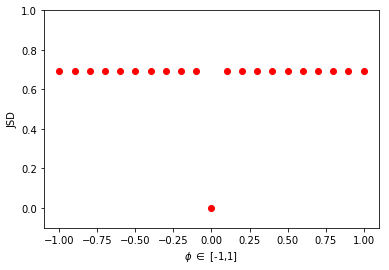

In [9]:
import matplotlib.pyplot as plt
plt.plot([j/10 for j in range(-10,11)],loss_JSD, 'ro')
plt.axis([-1.1, 1.1, -0.1, 1])
plt.xlabel('$\phi$ $\in$ [-1,1]')
plt.ylabel('JSD')
plt.show()

## Q1.2, 1.3:  Implement WD and Plot WD for $\phi \in [-1,1]$

In [6]:
import torch.nn as nn
import torch.nn.functional as F

def WD(Dx, Dy, dz, lambda_=10):
    """
    Args:
      param1: Dx, derivative wrt x \sim p
      param2: Dy, derivative wrt y \sim q
      param3: lambda, coef for GP
    Returns:
      Wasserstein Distance
    """
    wd = torch.mean(Dx) - torch.mean(Dy) - lambda_*torch.mean((torch.norm(dz, dim=1)-1)**2)
    return -wd

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer = nn.Linear(2, 32)
        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        x = F.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        return x

In [7]:
loss_WD = []
for j in range(-10, 11):
    net = Net()
    net.apply(init_weights)
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    for i in range(5000):
        x = torch.tensor(next(iter(distribution1(0, batch_size=512))), dtype=torch.float32)
        y = torch.tensor(next(iter(distribution1(j/10, batch_size=512))), dtype=torch.float32)
        a = torch.tensor(next(iter(distribution0(batch_size=512))), dtype=torch.float32)
        
        z = a*x + (1-a)*y
        z.retain_grad()
        z.requires_grad = True
        
        Dz = net(z)
        Dx = net(x)
        Dy = net(y)
        
        dz = torch.autograd.grad(Dz, z, grad_outputs=torch.ones_like(Dz), create_graph=True, retain_graph=True)[0]
        loss = WD(Dx, Dy, dz)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    loss_WD.append(-loss.item())
    print('loss:', loss.item())

loss: -1.0254085063934326
loss: -0.9205376505851746
loss: -0.8160801529884338
loss: -0.7122305035591125
loss: -0.6087612509727478
loss: -0.5065206289291382
loss: -0.4038587510585785
loss: -0.3021100163459778
loss: -0.20112594962120056
loss: -0.10039469599723816
loss: 0.002093208022415638
loss: -0.10081833600997925
loss: -0.20131038129329681
loss: -0.30236783623695374
loss: -0.40384307503700256
loss: -0.5061437487602234
loss: -0.609080970287323
loss: -0.7122768759727478
loss: -0.8159677982330322
loss: -0.9200686812400818
loss: -1.0249017477035522


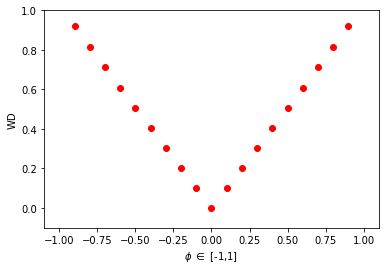

In [8]:
plt.plot([j/10 for j in range(-10,11)], loss_WD, 'ro')
plt.axis([-1.1, 1.1, -.1, 1])
plt.xlabel('$\phi$ $\in$ [-1,1]')
plt.ylabel('WD')
plt.show()

## Q1.4: Plot discriminator output and the estimated density

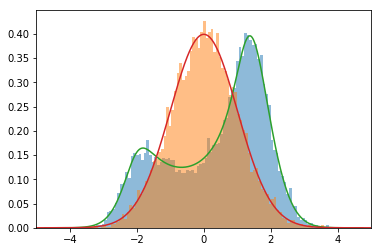

In [10]:

from __future__ import print_function
import numpy as np
import torch 
import matplotlib.pyplot as plt

# plot p0 and p1
plt.figure()

# empirical
xx = torch.randn(10000)
f = lambda x: torch.tanh(x*2+1) + x*0.75
d = lambda x: (1-torch.tanh(x*2+1)**2)*2+0.75
plt.hist(f(xx), 100, alpha=0.5, density=1)
plt.hist(xx, 100, alpha=0.5, density=1)
plt.xlim(-5,5)
# exact
xx = np.linspace(-5,5,1000)
N = lambda x: np.exp(-x**2/2.)/((2*np.pi)**0.5)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.plot(xx, N(xx))


In [11]:

############### import the sampler ``samplers.distribution4'' 
############### train a discriminator on distribution4 and standard gaussian
############### estimate the density of distribution4

#######--- INSERT YOUR CODE BELOW ---#######

def loss_distance(Dx, Dy):
    """
    Args:
      param1: Dx, derivative wrt x \sim p
      param2: Dy, derivative wrt y \sim q
    Returns:
      -(Ep[log(Dx) + Eq[1 - log(Dy)])
    """
    return -(torch.mean(torch.log(Dx)) + torch.mean(torch.log(1-Dy)))

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer = nn.Linear(1, 32)
        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        x = F.relu(self.hidden_layer(x))
        x = F.sigmoid(self.output_layer(x))
        return x

net = Net()
net.apply(init_weights)
optimizer = optim.Adam(net.parameters(), lr=0.001)
for i in range(5000):
    x = torch.tensor(next(iter(distribution4(batch_size=512))), dtype=torch.float32)
    y = torch.tensor(next(iter(distribution3(batch_size=512))), dtype=torch.float32)

    Dx = net(x)
    Dy = net(y)

    loss = loss_distance(Dx, Dy)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
####################

/home/zahra/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/home/zahra/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Text(0.5,1,'Estimated vs True')

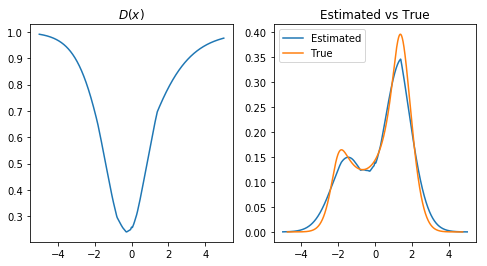

In [13]:
############### plotting things
############### (1) plot the output of your trained discriminator 
############### (2) plot the estimated density contrasted with the true density

# output of the trained discriminator
D_opt = net(torch.Tensor(xx.reshape(-1,1))) 
D_opt = np.array([d.data.item() for d in D_opt])

# estimate f1 density
f0 = N(xx)
f1 = (D_opt * f0) / (1 - D_opt)

# plotting
r = D_opt # evaluate xx using your discriminator; replace xx with the output
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(xx,r)
plt.title(r'$D(x)$')

estimate = f1 # estimate the density of distribution4 (on xx) using the discriminator; 
                                # replace "np.ones_like(xx)*0." with your estimate
plt.subplot(1,2,2)
plt.plot(xx,estimate)
plt.plot(f(torch.from_numpy(xx)).numpy(), d(torch.from_numpy(xx)).numpy()**(-1)*N(xx))
plt.legend(['Estimated','True'])
plt.title('Estimated vs True')
